In [325]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams
import matplotlib as mpl
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma, hyp1f1, erf, erfc

In [326]:
#Definition of the Key Parameters
#dim=100 #Dimension  of the Hilbert a.k.a Random matrices of dimension dim x dim
dim_arr=[5, 10, 20, 100]
A=1 #Probability distribution to take the RMT elements will be P~exp(-A x^2)
sigma=np.sqrt(A/2) #Standard deviation of the normal distribution
basis = np.identity(dim)
i=complex(0,1)
β=1 #Inverse temperature
tmax=50 #Maximum time we simulate. (Dimensionless) Typicaly the dip is found at t<=1
n_points_t=150 #Number of points in the time array
xlogscale=True #If True the time points will be uniformly distributed in logscale
if xlogscale:
    auxtmin=-2 #tmin=10**auxtmin
    auxtmax=np.log10(tmax)
    auxt=np.linspace(auxtmin, auxtmax, n_points_t)
    t_arr=10**(auxt)
else:
    t_arr=np.linspace(0, tmax, n_points_t)
Nav=1000 #Number of random matrices to average over
hbar=1 #We use hbar=1

#Comment on dimensions of quantities: 
#Both the time and the inverse temperature are dimensionless. The underlying dimension of
#energy is given by A which gives a dimension to the elements of the Random Matrix

In [327]:
#Basic subroutines:
#Compute the dot product between a bra and a ket. Returns a complex number
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
#Compute the product between a jet and a bra. Returns an operator over the Hilbert space
@numba.jit(complex128[:,:](complex128[:], complex128[:], int64), nopython=True, fastmath=True, parallel=False)
def ketbra(ket, bra, dim):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res

In [328]:
#Construct a Random Gaussian Orthogonal Matrix GOE (Time Reversal Symmetry is present)
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N) #Creates a random array normally distributed. Assumes sigma=1
    H=(auxH+auxH.T) #Summing any matrix and its transpose gives a symmetric matrix
    return H
#Construct a Random Gaussian Hermitian Matrix. GUE (No Time-Reversal Symmetry)
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False)
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128) #Define a N x N matrix
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma) #The elements in the diagonal are real.
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2) #Elements out of diagonal
            b=np.random.normal(0,sigma)/np.sqrt(2) #Take care with the sqrt(2) dividing
            #With this sqrt(2) the average modulus of the random numbers is the same as in 
            #the diagonal
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    return H
def unfoldSpectrum(E, order, n_bins, dim):
    Emax=np.max(E)
    Emin=np.min(E)
    rhoE, bins=np.histogram(E, bins=np.linspace(Emin, Emax, n_bins+1), density='True')
    bins=bins[:-1]
    N_E=np.zeros(n_bins)
    dummyE=0
    dE=(bins[1]-bins[0])
    for k in range(n_bins):
        dummyE+=rhoE[k]*dE
        N_E[k]=dummyE
    fit=np.polyfit(bins, N_E, order)
    polyn=np.poly1d(fit)
    unf_E=dim*polyn(E)
    rhoE_unf, bins=np.histogram(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins+1), density='True')
    stdrho=np.std(rhoE_unf)
    ndiscard=np.sum(rhoE_unf>1/dim+2*stdrho) # # bins with ρ(E)>1/N+2σ. # bins to discard
    unf_E=unf_E[unf_E>bins[ndiscard]]
    unf_E=unf_E[unf_E<bins[-1-ndiscard]]
    return unf_E

In [329]:
#Compute the analytically continued partition function given the spectrum E of the system
#The β parameter may be complex valued.
@numba.jit(complex128(complex128, float64[:]))
def Z_c(β, E):
    Z=np.sum(np.exp(-β*E))
    return Z

In [330]:
#Analytical expression obtained for F^(1)(t)/Z(2β)
def f_analytic(b, t):
    t1=-8*b*np.exp(np.pi*t*(2*i*b+t)/16)
    t2=np.exp(b**2*np.pi/16)*(8 + np.pi*(b-i*t)**2)
    t3=-np.exp(b**2*np.pi/16)*(8+ np.pi*(b-i*t)**2)*erf(np.sqrt(np.pi)*(b-i*t)/4)
    t4=np.exp(b*np.pi*(b+4*i*t)/16)*(8+np.pi*(b+i*t)**2)*erfc(np.sqrt(np.pi)*(b+i*t)/4)
    return np.exp(-np.pi*t*(2*i*b+t)/16)/8*(t1+t2+t3+t4)


In [331]:
#The commented lines of code compute the non-annealed version of F(β, t) using the 
#full definition. This is a very slow procedure, for this reason we usually compute 
#the annealed version directly from the product Z(β/2 + 2 i t)Z(β/2 - 2 i t) where Z is 
#computed numerically from the energies
#F_2_arr=np.zeros((n_points_t, Nav), dtype=complex)
#F_arr=np.zeros((n_points_t, Nav), dtype=complex)
#F_Z_arr=np.zeros((n_points_t, Nav), dtype=complex)
F_1_N=np.zeros((n_points_t, len(dim_arr)))
for l in range(len(dim_arr)):
    F_1_arr=np.zeros((n_points_t, Nav), dtype=complex)
    #Z_arr=np.zeros(Nav)
    for j in range(Nav):
        H=RMT_GUE(dim_arr[l], sigma) #Create random Matrix from GUE
        E, ket_n=eigh(H) #Diagonalize it
        if np.any(np.imag(E)>1e-8): 
            print("Problems") #Ensures that we have real eigenvalues
            print(np.max(np.imag(E)))
        #Z=np.real(Z_c(β, E)) #Computes the partition function at temperature β
        #Z_arr[j]=Z #Stores the partition function in an array to average it
        E=unfoldSpectrum(E, 15, 60, dim_arr[l])
        Z2b=np.real(Z_c(2*β, E))
        k=1
        s=[]
        auxfk=0
        for m in range(len(E)-k):
            s.append(E[m+k]-E[m])
        for n in range(len(s)):
            auxfk+=2*np.cos(t_arr*s[n])*np.exp(-β*(2*E[n]+s[n]))
        F_1_arr[:,j]=auxfk/Z2b

    F_1_N[:,l]=np.average(np.real(F_1_arr), axis=1)


/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


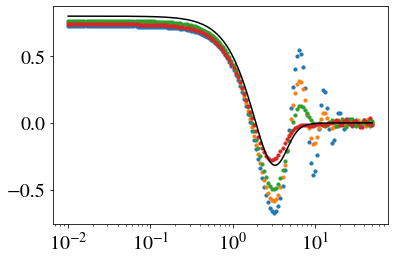

In [332]:
#print(np.max(np.abs(np.imag(F_k))))
auxf=f_analytic(β, t_arr)
plt.figure()
plt.plot(t_arr, auxf, color='black', zorder=10)
for l in range(len(dim_arr)):
    plt.scatter(t_arr, F_1_N[:,l], zorder=5, s=10)
plt.xscale('log')
plt.show()

/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/pablo/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


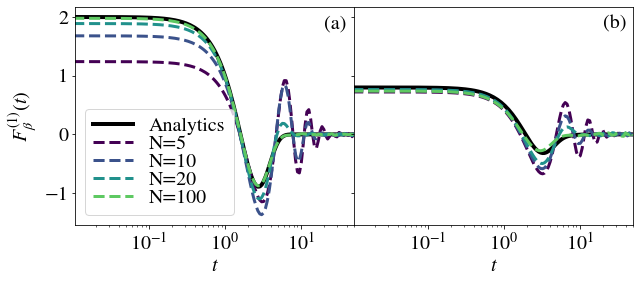

In [340]:
#fhat=np.real(F_Z/F_Z[0]) #Define Fhat=F(t)/F(0)ç

fig, (ax1, ax2)=plt.subplots(1, 2, sharey=True, figsize=[10, 4])

#ax1.scatter(t_arr, fhat_b0, color='red', s=10)
ax1.plot(t_arr, f_analytic(0, t_arr), lw=4, color='black', label="Analytics")
#ax2.scatter(t_arr, fhat, color='red', s=10)
ax2.plot(t_arr, f_analytic(1, t_arr), lw=4, color='black', label="Analytics")
cm = plt.get_cmap('viridis')
#ax.set_color_cycle([cm(1.*k/dim) for i in range(dim)])
for k in range(len(dim_arr)):
    lines = ax1.plot(t_arr, F_1_N_b0[:,k], lw=3, label="N="+str(dim_arr[k]), ls='--')
    lines[0].set_color(cm(k/len(dim_arr)))
    lines = ax2.plot(t_arr, F_1_N[:,k], lw=3, label="N="+str(dim_arr[k]), ls='--')
    lines[0].set_color(cm(k/len(dim_arr)))
#plt.scatter(t_arr, np.real(F_t/F_t[0]), label='Numerics GUE <./.>')
#cb=fig.colorbar(lines, ax=ax)
#cb.set_label("k")
plt.subplots_adjust(wspace=0)
ax1.set_xlabel("$t$")
ax1.set_ylabel(r"$F^{(1)}_\beta(t)$")
ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_xlim(t_arr[1],t_arr[-1])
ax2.set_xlabel("$t$")
#plt.yscale('log')
ax1.set_xlim(t_arr[1],t_arr[-1])
#plt.ylim(np.min(fhat), 1)
ax1.legend(labelspacing=0)
ax1.text(20,1.8, "(a)")
ax2.text(20,1.8, "(b)")
plt.show()

In [334]:
#F_1_N_b1=F_1_N
#F_1_N_b0=F_1_N